In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from pprint import pprint

In [81]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [43]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, asc, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [51]:
# Find the most recent date in the data set.
for row in session.query(measurement).order_by(desc(measurement.date)).limit(1).all():
    print(row.date)



2017-08-23


Text(0.5, 1.0, 'Precipitation over the last 12 months')

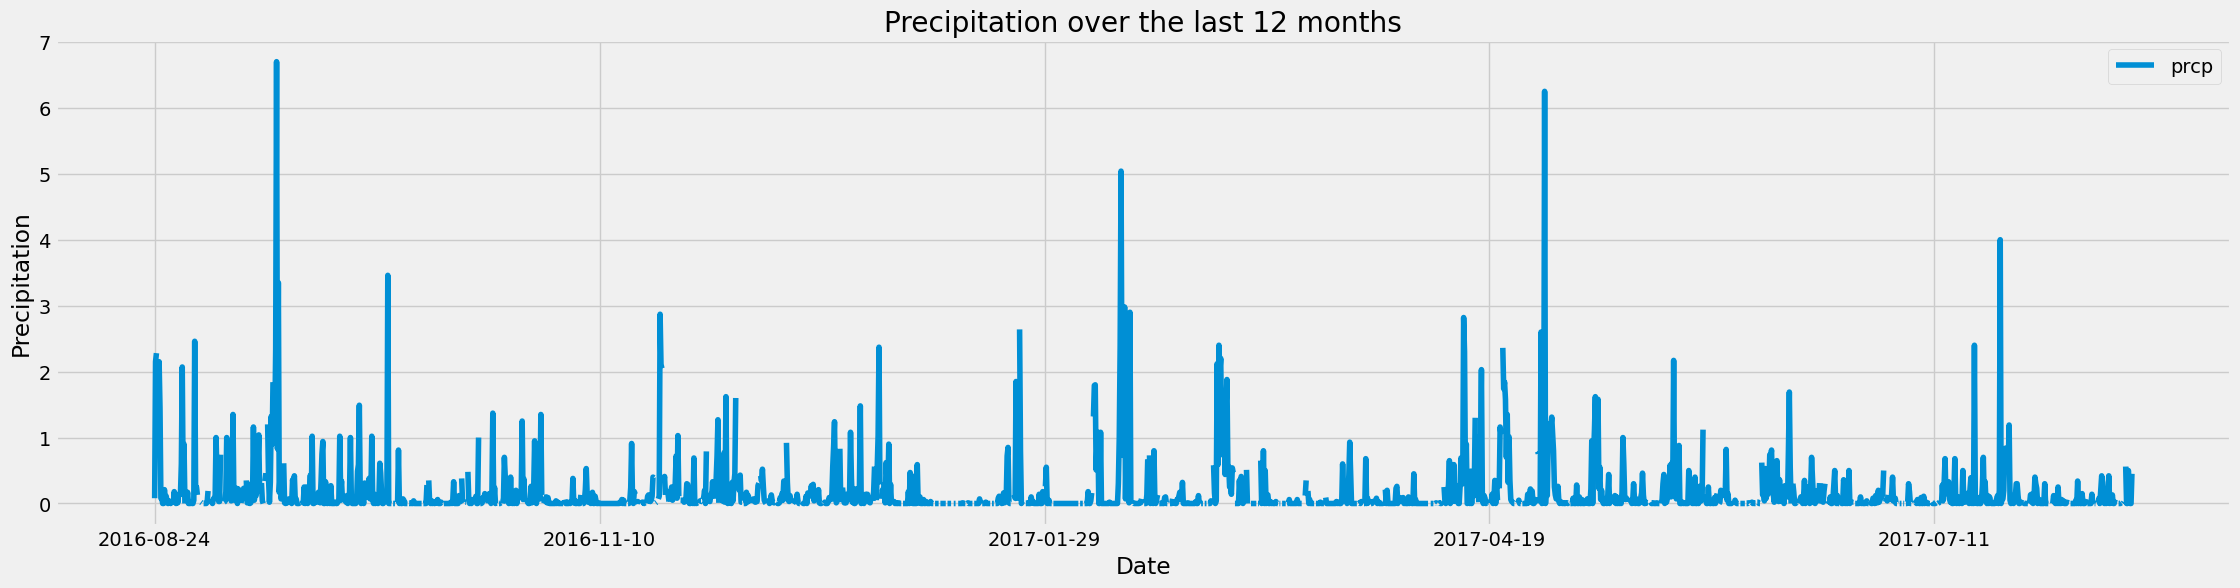

In [94]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(measurement.date).order_by(desc(measurement.date)).first()[0]


# Calculate the date one year from the last date in data set.
most_recent_date = dt.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
          filter(measurement.date <= most_recent_date).\
          filter(measurement.date >= one_year_ago).\
          order_by(measurement.date).all()                 


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results)

# Sort the dataframe by date
df_sorted = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df_sorted.plot(x='date', y='prcp', kind='line', figsize=(25, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation over the last 12 months')



In [96]:
# Use Pandas to calculate the summary statistics for the precipitation data
# We need count, mean, std, min, 25%, 50%, 75%, max

summary_stats = df_sorted['prcp'].describe(percentiles=[.25, .5, .75])
summary_stats

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [102]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
total_stations

9

In [112]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
                       group_by(measurement.station).\
                       order_by(desc(func.count(measurement.station)))

for station, count in most_active_stations:
    print(f'Station: {station}, Count: {count}')

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [117]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tobs_results = session.query(
          func.min(measurement.tobs),
          func.max(measurement.tobs),
          func.avg(measurement.tobs),          
        ).filter(measurement.station == 'USC00519281').one()
lowest, highest, average = tobs_results
print(tobs_results)

(54.0, 85.0, 71.66378066378067)


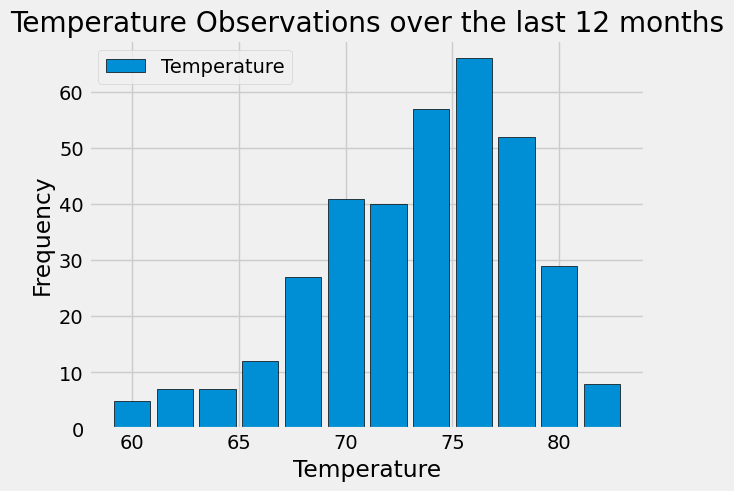

In [126]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
from sqlalchemy import and_

temp_data = session.query(measurement.tobs).\
            filter(and_(measurement.station == 'USC00519281', measurement.date >= one_year_ago)).all()

#Pull the temp out of the tuple into a list.
temps = [temp[0] for temp in temp_data]

#Plot that
plt.hist(temps, bins=12, label='Temperature', edgecolor='black', rwidth=0.85)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations over the last 12 months')
plt.legend()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()